In [ ]:
import pandas as pd 
import numpy as np
from bs4 import BeautifulSoup
import geopandas as gp
from shapely.geometry import Point, Polygon, LinearRing
import folium
import matplotlib.pyplot as plt

In C:\Users\User\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\User\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\User\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In C:\Users\User\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\User\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle

### Read in planning boundary areas dataset to get centroids for each planning area

In [ ]:
def kml_to_df(kml, planning_region, planning_area):
    dataset = str("C:\\Users\\User\\Desktop\\NOTES\\Notes_Y4S2\\BT4222\\HDB Project\\Interface\\") + kml
    infile = open(dataset)
    contents = infile.read()
    xml_data = BeautifulSoup(contents,'xml')
    no_of_rows = len(xml_data.find_all('SimpleData', {'name': planning_area}))
    
    rows = []
    for j in range(no_of_rows):
        region = xml_data.find("Placemark", {"id": 'kml_' + str(j+1)}).find("SimpleData", {"name": planning_region}).text
        area = xml_data.find("Placemark", {"id": 'kml_' + str(j+1)}).find("SimpleData", {"name": planning_area}).text
        coords = xml_data.find("Placemark", {"id": 'kml_' + str(j+1)}).find('coordinates').text.split(",0.0 ")
        lon_list = []
        lat_list = []
        for pair in coords: 
            lon_list.append(float(pair.split(",")[0]))
            lat_list.append(float(pair.split(",")[1]))
        polygon_geom = Polygon(zip(lon_list, lat_list))
        centroid = Point(polygon_geom.centroid)
        centroid_lon = centroid.coords[0][0]
        centroid_lat = centroid.coords[0][1]
        rows.append([region, area, polygon_geom, centroid_lon, centroid_lat])
    df = pd.DataFrame(rows, columns=["Planning_Region", "Planning Area", "Coordinates", "Centroid Longitude", "Centroid Latitude"])  
    
    return df

In [ ]:
area_coords = kml_to_df('planning-boundary-area.kml', 'REGION_N', 'PLN_AREA_N')

In [ ]:
area_coords.head(3)

,Planning_Region,Planning Area,Coordinates,Centroid Longitude,Centroid Latitude
0,CENTRAL REGION,BUKIT MERAH,"POLYGON ((103.817404504805 1.29433192068794, 1...",103.823548,1.273004
1,WEST REGION,BUKIT PANJANG,"POLYGON ((103.774450261573 1.39028945327231, 1...",103.772998,1.366822
2,CENTRAL REGION,BUKIT TIMAH,"POLYGON ((103.797658114828 1.34812847309287, 1...",103.790700,1.329997


C:\Users\User\Anaconda3\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


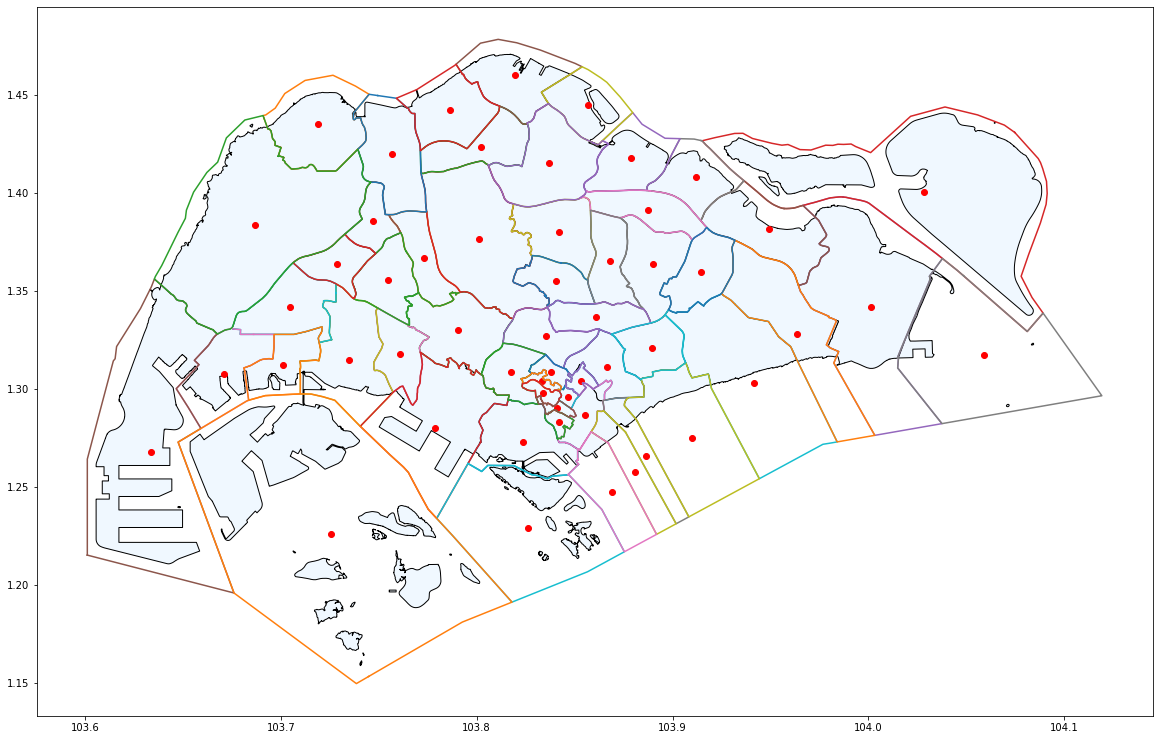

In [ ]:
sg_map = gp.read_file('C:\\Users\\User\\Desktop\\NOTES\\Notes_Y4S2\\BT4222\\HDB Project\\master-plan-2014-planning-area-boundary-no-sea-shp\\MP14_PLNG_AREA_NO_SEA_PL.shp')
sg_map = sg_map.to_crs(epsg=4326) 
fig, ax = plt.subplots(figsize=(20,20))
sg_map.plot(ax = ax, color = 'aliceblue', edgecolor = 'black')
centroid_gdf = gp.GeoDataFrame(area_coords, crs = {'init': 'epsg:4326'}, geometry = gp.points_from_xy(area_coords['Centroid Longitude'], area_coords['Centroid Latitude']))
centroid_gdf.plot(ax=ax, color = 'red')
for i in range(len(centroid_gdf)):
    plt.plot(*centroid_gdf.iloc[i]['Coordinates'].exterior.xy)

### See how one row looks like

In [ ]:
centroid_gdf[centroid_gdf['Planning Area'] == 'CLEMENTI']

,Planning_Region,Planning Area,Coordinates,Centroid Longitude,Centroid Latitude,geometry
6,WEST REGION,CLEMENTI,"POLYGON ((103.76706923941 1.33120211203399, 10...",103.76075,1.317586,POINT (103.76075 1.31759)


### Save centroids dataset as csv to be used for interface 

In [ ]:
centroid_gdf.to_csv('area_centroid.csv', index=False)

In [ ]:
from math import radians, cos, sin, asin, sqrt
def haversine(lon1, lat1, lon2, lat2): # find distance between 2 lisitng
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371 # Radius of earth in kilometers. Use 3956 for miles
    return c * r


In [ ]:
haversine(103.79070, 1.33000, 103.77663777, 1.3184590944)

2.0225045949153904

In [ ]:
haversine(103.76075	, 1.317586, 103.77663777, 1.3184590944)

1.768838263324773

### Map postal codes in dataset to their planning region and area. 

##### For postal codes existing in our preliminary_dataset.csv, we use the planning region, planning area, longitude and latitude derived for them before instead by saving those info into a separate file instead of having to run OneMap API again 




In [ ]:
prelim_data = pd.read_csv('Interface/datasets/preliminary_dataset.csv')
prelim_data['Postal Code'] = prelim_data['Postal Code'].apply(lambda x: str(x).zfill(6))

In [ ]:
postal_code_region = {}
for index, row in prelim_data.iterrows():
    postal_code_region[row['Postal Code']] = [row['Planning Region'].upper(), row['Planning Area'].upper(), row['LONGITUDE'], row['LATITUDE']]

In [ ]:
postal_code_region_df = pd.DataFrame.from_dict(data=postal_code_region, orient = 'index').reset_index()#.to_csv('dict_file.csv')
postal_code_region_df.columns = ['Postal Code', 'Planning Region', 'Planning Area', 'LONGITUDE', 'LATITUDE']
postal_code_region_df.to_csv('Interface/datasets/historical_postal_code_area.csv', index = False)